In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from matplotlib import ticker
import astropy.units as u
from astropy.coordinates import SkyCoord
import pickle
import emcee
from sourcedictionary import source_dict
from plot_utils import source_label, trans_label, get_param_names
from ammonia_hfs_model import NH3_model, NH2D_model, populate_params
from spectroscopic_data import (
    NH3_pf,
    NH2D_pf,
    ortho_NH3_pf,
    para_NH3_pf,
    get_spectroscopic_data,
)
from mcmc_tools import EmceeHammer
from qdisk.classes import FitsImage
%matplotlib widget
%load_ext autoreload
%autoreload 2

imagepath = "/raid/work/yamato/IRAS4A_ammonia/"
spectrumpath = "./data/spectrum/"
fitdatapath = "./data/fit/"

sources = ["IRAS4A1", "IRAS4A2"]
transition = ["NH3_33", "NH3_44", "NH3_55", "NH2D_33", "NH2D_44"]
fit_type = ["OPR_free", "OPR_fixed"]

plt.rcParams.update(
    {
        "text.usetex": True,
        "font.family": "serif",
        "font.sans-serif": ["Times"],
        "xtick.top": True,
        "ytick.right": True,
        "xtick.direction": "in",
        "ytick.direction": "in",
    }
)

colors = {"OPR_fixed": "tab:blue", "OPR_free": "tab:orange"}
unit = "K"

nburnin = 2000

pf = {
    "OPR_free": {
        "NH3_33": ortho_NH3_pf,
        "NH3_44": para_NH3_pf,
        "NH3_55": para_NH3_pf,
        "NH2D_33": NH2D_pf,
        "NH2D_44": NH2D_pf,
    },
    "OPR_fixed": {
        "NH3_33": NH3_pf,
        "NH3_44": NH3_pf,
        "NH3_55": NH3_pf,
        "NH2D_33": NH2D_pf,
        "NH2D_44": NH2D_pf,
    },
}

nmodel = 20
dv = 0.01

Data used for partition function: /home/yamato/Project/IRAS4A_ammonia/data/partition_function/NH3_partition_function_fromRotConst.dat
Data are linearly interpolated.
Data used for partition function: /home/yamato/Project/IRAS4A_ammonia/data/partition_function/o-NH3_partition_function_fromRotConst.dat
Data are linearly interpolated.
Data used for partition function: /home/yamato/Project/IRAS4A_ammonia/data/partition_function/p-NH3_partition_function_fromRotConst.dat
Data are linearly interpolated.
Data used for partition function: /home/yamato/Project/IRAS4A_ammonia/data/partition_function/NH2D_partition_function.dat
Data are linearly interpolated.


Set OBSGEO-B to    34.078827 from OBSGEO-[XYZ].
Set OBSGEO-H to     2115.607 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to    34.078827 from OBSGEO-[XYZ].
Set OBSGEO-H to     2115.607 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to    34.078827 from OBSGEO-[XYZ].
Set OBSGEO-H to     2115.607 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


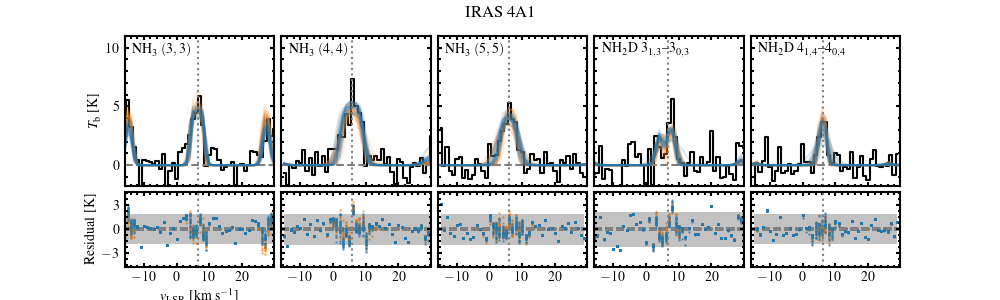

In [4]:
source = "IRAS4A1"
peak_coord = source_dict["IRAS4A"][source]["radec"]

fig, axes = plt.subplots(nrows=2, ncols=5, sharex=True, sharey="row", gridspec_kw=dict(height_ratios=(3, 1.5), wspace=0.05, hspace=0.05), figsize=(10, 3))

for i, trans in enumerate(transition):

    main_ax = axes[0, i]
    res_ax = axes[1, i]

    # observed spectra
    spectrum_file = (
        spectrumpath
        + "{:s}_{:s}.robust2.0.dv1.0.clean.image.pbcor.fits.spectrum.pickle".format(
            source, trans
        )
    )
    with open(spectrum_file, "rb") as f:
        data = pickle.load(f)

    # unit conversion
    velax = data.coord.pixel_to_world(np.arange(data.spectrum.size)).quantity.to(
        u.km / u.s, equivalencies=u.doppler_radio(data.restfreq)
    )
    spec = data.spectrum.to(
        unit, equivalencies=u.brightness_temperature(data.restfreq, data.beam)
    )
    error = data.rms.to(
        unit, equivalencies=u.brightness_temperature(data.restfreq, data.beam)
    )

    # flag bad channels
    velax = velax[error != 0.0]
    spec = spec[error != 0.0]

    # beam
    beam = (data.beam.major.to(u.arcsec).value, data.beam.minor.to(u.arcsec).value)

    # plot
    main_ax.plot(velax, spec, color="black", drawstyle="steps-mid")
    main_ax.axhline(y=0.0, color="grey", ls="dashed")
    main_ax.set(xlim=(-15.8, 29.8), ylim=(-1.8, 11))

    # get spectroscopic data
    rotdata = get_spectroscopic_data(trans, hfs=False)
    hfsdata = get_spectroscopic_data(trans, hfs=True)

    # high resolution velocity axis
    dv_orig = np.diff(velax).mean().value
    velax_hires = (
        np.arange(velax.min().value - dv_orig, velax.max().value + dv_orig, dv) * velax.unit
    )
    rms = np.nanmedian(error.value)

    for j, ft in enumerate(fit_type):
        samplerfile = (
            fitdatapath
            + f"{source}_NH3_33_NH3_44_NH3_55_NH2D_33_NH2D_44_{ft}_v2.h5"
        )
        hammer = EmceeHammer()
        hammer.load_backend(samplerfile)
        params = hammer.get_random_sample_params(nburnin=nburnin, nsample=nmodel)

        v0_sample = []
        for p in params:
            dv_FWHM, v0, N, T, s = populate_params(p, transition, ft)
            spec_model = NH3_model if "NH3" in trans else NH2D_model
            
            spectrum = spec_model(
                velax=velax,
                beam=beam,
                rotdata=rotdata,
                hfsdata=hfsdata,
                dv_FWHM=dv_FWHM[trans],
                v0=v0[trans],
                N=N[trans],
                T=T,
                s=s,
                pf=pf[ft][trans],
            ).to("K", equivalencies=u.brightness_temperature(data.restfreq, data.beam))
            v0_sample.append(v0[trans].value)

            main_ax.plot(velax, spectrum, color=colors[ft], alpha=0.15)

            # residual plot
            res_ax.scatter(velax, spec - spectrum, color=colors[ft], alpha=0.5, s=3, marker=".")
            res_ax.set(ylim=(-5*rms, 5*rms))
            res_ax.axhline(y=0.0, color="grey", ls="dashed", zorder=-100)
            res_ax.fill_between(velax.value, y1=-2*rms, y2=2*rms, color="grey", alpha=0.01, edgecolor=None)
            
        
    main_ax.axvline(x=np.median(v0_sample), color="grey", ls="dotted")
    res_ax.axvline(x=np.median(v0_sample), color="grey", ls="dotted")
    main_ax.text(0.05, 0.95, trans_label[trans], transform=main_ax.transAxes, ha="left", va="top")

    if i == 0:
        main_ax.set(ylabel="$T_\mathrm{b}$ [K]")
        res_ax.set(xlabel="$v_\mathrm{LSR}$ [km s$^{-1}$]", ylabel="Residual [K]")

    # ticker
    main_ax.xaxis.set_major_locator(ticker.MultipleLocator(10))
    res_ax.yaxis.set_major_locator(ticker.MultipleLocator(3))
            
fig.suptitle("IRAS 4A1")

fig.savefig("IRAS4A1_spectrum_fit_residual.pdf", bbox_inches="tight", pad_inches=0.01)



In [22]:
data.rms

<Quantity [0.        , 0.00214544, 0.00084293, 0.00067672, 0.00062311,
           0.00060073, 0.0005749 , 0.0005699 , 0.00056116, 0.00055865,
           0.00055272, 0.00053788, 0.0005336 , 0.00056207, 0.00053655,
           0.0005455 , 0.00056992, 0.00056155, 0.00056971, 0.00057498,
           0.00057431, 0.0005659 , 0.00056629, 0.00056705, 0.00056858,
           0.00054875, 0.00057209, 0.00057305, 0.00056855, 0.00055899,
           0.00054922, 0.00054078, 0.00053832, 0.00054069, 0.00053633,
           0.00054281, 0.00053295, 0.00053558, 0.00052508, 0.00051977,
           0.00053283, 0.00052903, 0.00051513, 0.00051522, 0.00054006,
           0.00082067, 0.        ] Jy / beam>